In [94]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [95]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import smogn
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
from scipy import ndimage
from itertools import compress

In [96]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (45,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [97]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 0
reextract = 0
resmogn_ds = 0
reload = 0
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/media/mts_dbs/dbs/complete_cases/nii/qsm/'
s_directory = '/media/mts_dbs/dbs/complete_cases/nii/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)

case_list = []
d_count = 0
if reload == 1:
    for seg_filename in s_directory:
        id = seg_filename[12:14]
        seg = nib.load('/media/mts_dbs/dbs/complete_cases/nii/seg/'+seg_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())
        qsm = nib.load('/media/mts_dbs/dbs/complete_cases/nii/qsm/qsm_'+str(id)+'.nii.gz')
        qsms.append(qsm.get_fdata())
        print('Appending arrays with segmentation',seg_filename,'and QSM','qsm_'+str(id)+'.nii.gz')
        case_list.append('qsm_'+str(id)+'.nii.gz')
        n_cases = len(segs)
        d_count = d_count+1
        qsms_wl = np.asarray(qsms)
        segs_wl = np.asarray(segs)
        with open('./pickles/segs', 'wb') as fp:  
            pickle.dump(segs, fp)

        with open('./pickles/qsms', 'wb') as fp:  
            pickle.dump(qsms, fp)

else:
    with open('/data/Ali/RadDBS-QSM/src/jupyter/pickles/segs', "rb") as fp:  
        segs = pickle.load(fp)

    with open('/data/Ali/RadDBS-QSM/src/jupyter/pickles/qsms', "rb") as fp:  
        qsms = pickle.load(fp)

In [98]:
if visualize == 1:
    qsms_wl = np.asarray(qsms)
    segs_wl = np.asarray(segs)
    qsms_wl[qsms_wl < m1] = m1
    qsms_wl[qsms_wl > m2] = m2
    n_cases = len(segs)
    multi_slice_viewer(np.hstack(((np.vstack(qsms_wl[:n_cases//2,:,:,:]/1000+0*segs_wl[:n_cases//2,:,:,:]).T),
                                  (np.vstack(qsms_wl[(n_cases-n_cases//2):,:,:,:]/1000+0*segs_wl[(n_cases-n_cases//2):,:,:,:]).T))))
   
                                    
    label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
    label_max = np.amax(seg.get_fdata())

In [99]:
file_dir = '/data/Ali/RadDBS-QSM/src/csv'
# Load patient data
os.chdir(file_dir)
df = pd.read_csv('QSM anonymus- 6.22.2023-1528.csv')

In [100]:
# Make a copy
dfd = df.copy()
# Drop blank columns
for (columnName, columnData) in dfd.iteritems():
    if columnData.isnull().all():
        print('Dropping NaN column at',columnName)
        dfd.drop(columnName,axis=1,inplace=True)
# Add relevant column names from headers
for (columnName, columnData) in dfd.iteritems():
        dfd.rename(columns={columnName:columnName+': '+columnData.values[0]},inplace=True)

def drop_prefix(self, prefix):
    self.columns = self.columns.str.lstrip(prefix)
    return self

pd.core.frame.DataFrame.drop_prefix = drop_prefix

dfd.drop_prefix('Unnamed:')        
for (columnName, columnData) in dfd.iteritems():
    if columnName[1].isdigit():
        dfd.rename(columns={columnName:columnName[4:]},inplace=True)

# Make a copy for motor symptoms
motor_df = dfd.copy()
# Drop non-motor (III) columns
for (columnName, columnData) in motor_df.iteritems():
    if 'pre-dbs updrs' in columnName:
        next
    elif 'stim' in columnName:
        next
    elif 'CORNELL ID' in columnName:
        next
    else:
        motor_df.drop(columnName,axis=1,inplace=True)

# Drop subheader
motor_df = motor_df.tail(-1)
motor_df = motor_df.replace('na',np.nan)
motor_df

,CORNELL ID,OFF (pre-dbs updrs),ON (pre-dbs updrs),OFF meds ON stim 6mo,ON meds ON stim 6mo,off stim on med 6mo,off stim off med 6mo
1,67,60,41,31,29,NaN,NaN
2,only Ct data,43,12,NaN,20,18,NaN
3,74,34,11,NaN,17,NaN,NaN
4,84,53,13,NaN,34,NaN,NaN
5,75,62,8,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...
87,52,58,27,19,12,NaN,NaN
88,53,77,47,NaN,19,26,NaN
89,54,63,36,8,NaN,NaN,NaN
90,55,40,29,NaN,13,NaN,37


In [101]:
id = []
for seg_filename in s_directory:
    id.append(seg_filename[12:14])
df_post_dbs_off_meds_on_stim = motor_df['OFF meds ON stim 6mo'].to_numpy().astype('float')
df_post_dbs_off_meds_off_stim = motor_df[' off stim off med 6mo'].to_numpy().astype('float')
df_pre_dbs_off_meds = motor_df['OFF (pre-dbs updrs)'].to_numpy().astype('float')
df_pre_dbs_on_meds = motor_df['ON (pre-dbs updrs)'].to_numpy().astype('float')

cases = ~np.isnan(df_pre_dbs_off_meds+df_pre_dbs_on_meds+df_post_dbs_off_meds_on_stim)
pre_dbs_meds_improvement = (df_pre_dbs_off_meds[cases]-df_pre_dbs_on_meds[cases])/df_pre_dbs_off_meds[cases]
dbs_off_meds_improvement = (df_pre_dbs_off_meds[cases]-df_post_dbs_off_meds_on_stim[cases])/df_pre_dbs_off_meds[cases]
motor_df['CORNELL ID'].replace('only Ct data ', np.nan, inplace=True)
pids = motor_df['CORNELL ID'].to_numpy().astype('float')
subs = pids[cases]
subs_in = (np.intersect1d(subs,np.asarray(id).astype(float)))
df_pre_dbs_off_meds_in = df_pre_dbs_off_meds[cases]
pre_dbs_off_meds_in = df_pre_dbs_off_meds_in[np.in1d(subs,np.asarray(id).astype(float))]

In [102]:
if reextract == 1:
    logger = logging.getLogger("radiomics")
    logger.setLevel(logging.ERROR)

    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    roi_txt = pd.read_csv("/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv")
    roi_df = roi_txt.astype(str)
    packet = [*zip(qsms,segs,subs_in,pre_dbs_off_meds_in)]
    def extract(qsm,seg,sub_in,pre_dbs_off_meds_in):
        fv_count = 0
        seg_labels_all = [0,1,2,3,4,5,6,7]
        Phi_gt = []
        x_row_gt = []
        keylib = []
        roilib = []
        roi_names = []
        voxel_size = ((0.5,0.5,0.5))
        seg_sitk = sitk.GetImageFromArray(seg)
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsm)
        qsm_sitk_gt.SetSpacing(voxel_size)
        for j in seg_labels_all:
            if 0 < j < 7:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(j)
                        mask = np.row_stack([roi_df[row].str.contains(str(int(roilib[-1])), na = False) for row in roi_df])
                        roi_names.append(np.asarray(roi_df.iloc[mask.any(axis=0),1])[0])
                x_row_gt.append(pre_dbs_off_meds_in)
                fv_count = fv_count+1
                print('Extracting features for subject',sub_in,
                    'ROI',j,'and appending feature matrix with vector of length',
                    fv_count,'with UPDRS score',pre_dbs_off_meds_in)

        X0_gt = np.array(x_row_gt)
        npy_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/X0_gt_msw_rois'+str(sub_in)+'.npy'
        np.save(npy_file,X0_gt)
        K = np.asarray(keylib)
        R = np.asarray(roi_names)
        K_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/K_msw'+str(sub_in)+'.npy'
        R_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/R_msw'+str(sub_in)+'.npy'
        np.save(K_file,K)
        np.save(R_file,R)
        Phi_file = '/data/Ali/RadDBS-QSM/src/jupyter/phi/Phi_mcl_gt_roi_msw'+str(sub_in)
        print('Saving ground truth feature vector')
        with open(Phi_file, 'wb') as fp:  
            pickle.dump(Phi_gt, fp)

    pool = Pool(os.cpu_count()-5)
    results = pool.starmap(extract,packet)

    

In [103]:
def window3D(w):
    # Convert a 1D filtering kernel to 3D
    # eg, window3D(numpy.hanning(5))
    L=w.shape[0]
    m1=np.outer(np.ravel(w), np.ravel(w))
    win1=np.tile(m1,np.hstack([L,1,1]))
    m2=np.outer(np.ravel(w),np.ones([1,L]))
    win2=np.tile(m2,np.hstack([L,1,1]))
    win2=np.transpose(win2,np.hstack([1,2,0]))
    win=np.multiply(win1,win2)
    return win

In [104]:
def k_crop(im,factor,win):
    (cx,cy,cz) = (im.shape[0]//factor,im.shape[1]//factor,im.shape[2]//factor)
    win = win[(cx-(cx//2)):(cx+(cx//2)),(cy-(cy//2)):(cy+(cy//2)),(cz-(cz//2)):(cz+(cz//2))]
    print('Cropping to',str(cx),str(cy),str(cz),'from',str((cx-(cx//2))),'to',str((cx+(cx//2))),'and',str((cy-(cy//2))),'to',str((cy+(cy//2))),'and',str((cz-(cz//2))),'to',str((cz+(cz//2))))
    im_k = np.real(np.fft.ifftn(np.fft.ifftshift(win*(np.fft.fftshift(np.fft.fftn(im))[(cx-(cx//2)):(cx+(cx//2)),(cy-(cy//2)):(cy+(cy//2)),(cz-(cz//2)):(cz+(cz//2))]))))
    plt.imshow(im_k[:,:,(cz//2)-10])
    return im_k

In [105]:
if reextract == 1:
    logger = logging.getLogger("radiomics")
    logger.setLevel(logging.ERROR)

    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    roi_txt = pd.read_csv("/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv")
    roi_df = roi_txt.astype(str)
    packet = [*zip(qsms,segs,subs_in,pre_dbs_off_meds_in)]

    def extract_ds(qsm,seg,sub_in,pre_dbs_off_meds_in):
        def window3D(w):
            # Convert a 1D filtering kernel to 3D
            # eg, window3D(numpy.hanning(5))
            L=w.shape[0]
            m1=np.outer(np.ravel(w), np.ravel(w))
            win1=np.tile(m1,np.hstack([L,1,1]))
            m2=np.outer(np.ravel(w),np.ones([1,L]))
            win2=np.tile(m2,np.hstack([L,1,1]))
            win2=np.transpose(win2,np.hstack([1,2,0]))
            win=np.multiply(win1,win2)
            return win
        def k_crop(im,factor,win):
            (cx,cy,cz) = (im.shape[0]//factor,im.shape[1]//factor,im.shape[2]//factor)
            win = win[(cx-(cx//2)):(cx+(cx//2)),(cy-(cy//2)):(cy+(cy//2)),(cz-(cz//2)):(cz+(cz//2))]
            im_k = np.real(np.fft.ifftn(np.fft.ifftshift(win*(np.fft.fftshift(np.fft.fftn(im))[(cx-(cx//2)):(cx+(cx//2)),(cy-(cy//2)):(cy+(cy//2)),(cz-(cz//2)):(cz+(cz//2))]))))
            return im_k
        def seg_resize(im,factor):
            seg_k = ndimage.zoom(im,1/factor,order=0)
            return seg_k
        fv_count = 0
        seg_labels_all = [0,1,2,3,4,5,6,7]
        Phi_ds = []
        x_row_ds = []
        keylib = []
        roilib = []
        roi_names = []
        voxel_size = 2*((0.5,0.5,0.5))
        seg_sitk = sitk.GetImageFromArray(seg_resize(seg,2))
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(k_crop(qsm,2,window3D(np.hanning(qsm.shape[0]))))
        qsm_sitk_gt.SetSpacing(voxel_size)
        for j in seg_labels_all:
            if 0 < j < 7:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                Phi_ds.append(featureVector_gt)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_ds.append(featureVector_gt[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(j)
                        mask = np.row_stack([roi_df[row].str.contains(str(int(roilib[-1])), na = False) for row in roi_df])
                        roi_names.append(np.asarray(roi_df.iloc[mask.any(axis=0),1])[0])
                x_row_ds.append(pre_dbs_off_meds_in)
                fv_count = fv_count+1
                print('Extracting features for subject',sub_in,
                    'ROI',j,'and appending feature matrix with vector of length',
                    fv_count,'with UPDRS score',pre_dbs_off_meds_in)

        X0_ds = np.array(x_row_ds)
        npy_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/X0_ds_msw_rois'+str(sub_in)+'.npy'
        np.save(npy_file,X0_ds)
        K_ds = np.asarray(keylib)
        R_ds = np.asarray(roi_names)
        K_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/K_msw_ds'+str(sub_in)+'.npy'
        R_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/R_msw_ds'+str(sub_in)+'.npy'
        np.save(K_file,K_ds)
        np.save(R_file,R_ds)
        Phi_file = '/data/Ali/RadDBS-QSM/src/jupyter/phi/Phi_mcl_ds_roi_msw'+str(sub_in)
        print('Saving ground truth feature vector')
        with open(Phi_file, 'wb') as fp:  
            pickle.dump(Phi_ds, fp)

    pool = Pool(os.cpu_count()-5)
    results = pool.starmap(extract_ds,packet)

    

In [106]:
Phi_all = []
n_rois = 6
n_features = 1596
n_cases = 21
X_all = np.zeros((n_cases,n_rois,n_features))
R_all = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
K_all = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
phi_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw')
X_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw/X')
R_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw/R')
K_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw/K')
# Load all feature structures
for feature_matrix in phi_directory:
    with open('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw/'+feature_matrix, "rb") as fp:  
        Phi_case = pickle.load(fp)
        Phi_all.append(Phi_case)

# Load feature arrays
count = 0
for feature_array in X_directory:
    X_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw/X/'+feature_array)
    X_all[count,:,:] = X_case.reshape((n_rois,n_features)).transpose((0,1))
    count = count+1

# Load ROI indices
count = 0
for feature_roi in R_directory:
    R_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw/R/'+feature_roi)
    R_all[count,:,:] = R_case.reshape((n_rois,n_features-1)).transpose((0,1))
    count = count+1

# Load key indices
count = 0
for feature_key in K_directory:
    K_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw/K/'+feature_key)
    K_all[count,:,:] = K_case.reshape((n_rois,n_features-1)).transpose((0,1))
    count = count+1


In [107]:
Phi_all_ds = []
n_rois = 6
n_features = 1596
n_cases = 21
ids_in = []
X_all_ds = np.zeros((n_cases,n_rois,n_features))
R_all_ds = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
K_all_ds = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
phi_directory_ds = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw_ds')
X_directory_ds = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_ds/X_ds')
R_directory_ds = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_ds/R_ds')
K_directory_ds = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_ds/K_ds')
# Load all feature structures
for feature_matrix in phi_directory_ds:
    with open('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw_ds/'+feature_matrix, "rb") as fp:  
        Phi_case = pickle.load(fp)
        Phi_all_ds.append(Phi_case)
        ids_in.append(feature_matrix[-4:].replace('w',''))
# Load feature arrays
count = 0
for feature_array in X_directory_ds:
    X_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_ds/X_ds/'+feature_array)
    X_all_ds[count,:,:] = X_case.reshape((n_rois,n_features)).transpose((0,1))
    count = count+1

# Load ROI indices
count = 0
for feature_roi in R_directory_ds:
    R_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_ds/R_ds/'+feature_roi)
    R_all_ds[count,:,:] = R_case.reshape((n_rois,n_features-1)).transpose((0,1))
    count = count+1

# Load key indices
count = 0
for feature_key in K_directory_ds:
    K_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_ds/K_ds/'+feature_key)
    K_all_ds[count,:,:] = K_case.reshape((n_rois,n_features-1)).transpose((0,1))
    count = count+1


In [108]:
ids_in

['11.0',
 '32.0',
 '26.0',
 '27.0',
 '12.0',
 '13.0',
 '45.0',
 '41.0',
 '20.0',
 '9.0',
 '6.0',
 '1.0',
 '3.0',
 '29.0',
 '2.0',
 '34.0',
 '46.0',
 '15.0',
 '16.0',
 '10.0',
 '44.0']

In [109]:
ut_ls = np.zeros((n_cases))
ut_qr = np.zeros((n_cases))

ut_lsds = np.zeros((n_cases))
ut_qrds = np.zeros((n_cases))
# Normalize testing and training cases together
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However, need a significant number of samples to do this
X_all_r = X_all.reshape(n_cases,((n_features)*n_rois))
X_all_rds = X_all_ds.reshape(n_cases,((n_features)*n_rois))
scaler = StandardScaler()
# Transform feature matrix and UPDRS
X_all_t = scaler.fit_transform(X_all_r)
X_all_t_ds = scaler.fit_transform(X_all_rds)

In [110]:
dbs_off_meds_improvement_in = dbs_off_meds_improvement[np.in1d(subs,np.asarray(ids_in).astype(float))]

In [111]:
pre_dbs_meds_improvement_in = pre_dbs_meds_improvement[np.in1d(subs,np.asarray(ids_in).astype(float))]

In [112]:
if resmogn_ds == 1:
    # Create data frame for SMOGN generation
    D = pd.DataFrame(np.hstack((X_all_t_ds,(np.asarray(dbs_off_meds_improvement_in).reshape(n_cases,1)))))
    for col in D.columns:
        D.rename(columns={col:str(col)},inplace=True)

    # Specify phi relevance values
    Rm = [[np.min(dbs_off_meds_improvement_in),  1, 0],  ## over-sample ("minority")
        [np.mean(dbs_off_meds_improvement_in), 0, 0], ## under-sample ("majority")
        [np.max(dbs_off_meds_improvement_in), 1, 0]]

    # Conduct SMOGN
    print('Prior to SMOGN sampling, mean is',X_all_t_ds.mean(),'standard deviation is',X_all_t_ds.std())
    X_smogn_ds = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm)

    # Drop label
    X_in_s_ds = np.array(X_smogn_ds)[:,:-1] 
    print('After SMOGN sampling, mean is',X_in_s_ds.mean(),'standard deviation is',X_in_s_ds.std())
    print('Passing SMOGN augmented dataset of size',len(X_smogn_ds))
    for j in np.arange(X_in_s_ds.shape[1]):
        if np.array_equal(X_in_s_ds[:,j],np.array(X_smogn_ds)[:,-1]) == 0:
            next
        else:
            print('Labels detected at column',j)
    X_in_s0_ds = scaler.fit_transform(X_in_s_ds)
    print('Standardizing the SMOGN dataset gives, mean',X_in_s0_ds.mean(),'standard deviation',X_in_s0_ds.std())
else:
    X_smogn_ds = np.load('/media/mts_dbs/dbs/all/npy/SMOGN/X_smogn_test_updrs_lr_c.npy')
    # Drop label
    X_in_s_ds = np.array(X_smogn_ds)[:,:-1] 
    for j in np.arange(X_in_s_ds.shape[1]):
        if np.array_equal(X_in_s_ds[:,j],np.array(X_smogn_ds)[:,-1]) == 0:
            next
        else:
            print('Labels detected at column',j)
    X_in_s0_ds = scaler.fit_transform(X_in_s_ds)

In [113]:
n_cases_train = n_cases
Cs_ds = np.zeros_like(X_in_s_ds)
C_ds = np.zeros_like(X_all_t_ds)
for j in np.arange(n_cases_train):
        # Add UPDRS after scaling
        # Initialize training feature matrix
        X_in = X_all_t_ds
        X_in_t = X_all_t_ds[j,:]
        X_in = np.delete(X_in,j,axis=0)
        if j < X_in_s_ds.shape[0]: 
                # Drop the label in SMOGN array
                X_in_s_ds = X_in_s0_ds 
                # Drop the test case features
                X_in_s_ds = np.delete(X_in_s_ds,j,axis=0)
                # Create training label array from the SMOGN array
                smogn_per_change_in = np.asarray(X_smogn_ds)[:,-1]
                per_change_t = smogn_per_change_in[j]
                # Drop the test case labels
                smogn_per_change_in = np.delete(smogn_per_change_in,j,axis=0)
                for k in np.arange(smogn_per_change_in.shape[0]):
                        if j < X_in_s_ds.shape[0]: 
                                if smogn_per_change_in[k] == per_change_t:
                                        print('SMOGN target matches test target at row',str(k))
                                        if np.array_equal(X_in_s_ds[k,:],X_in_t):
                                                print('Test case and label detected at row',k,'case',j)
                                        else:
                                                print('But MSE of SMOGN feature matrix and test feature matrix is',np.sum(np.sqrt((X_in_s_ds[k,:]-X_in_t)**2)))

                                else:
                                        next
                # Train LASSO on SMOGN
                clf_s = Lasso(alpha=1e-4,max_iter=10000).fit(X_in_s_ds,smogn_per_change_in)
                # Get the features LASSO-SMOGN uses
                Cs_ds[j] = clf_s.coef_

        # Initialize training labels
        per_change_in = dbs_off_meds_improvement_in
        per_change_in = np.delete(per_change_in,j,axis=0)
  
        # Cross-validation for model selection
        # Identify most important features
        clf_ls = Lasso(alpha=1e-4,max_iter=10000).fit(X_in,per_change_in)
        ut_ls[j] = clf_ls.predict(X_all_t_ds[j,:].reshape(1, -1))
        ut_qr[j] = clf_s.predict(X_all_t_ds[j,:].reshape(1, -1))
        print('Testing patient',subs_in[j],'with pre-surgical UPDRS score',str(dbs_off_meds_improvement_in[int(j)]),'at feature matrix row',str(j))

SMOGN target matches test target at row 6
But MSE of SMOGN feature matrix and test feature matrix is 1830.311819651267
Testing patient 1.0 with pre-surgical UPDRS score 0.8307692307692308 at feature matrix row 0
SMOGN target matches test target at row 12
But MSE of SMOGN feature matrix and test feature matrix is 12305.63866982822
Testing patient 2.0 with pre-surgical UPDRS score 0.9090909090909091 at feature matrix row 1
SMOGN target matches test target at row 13
But MSE of SMOGN feature matrix and test feature matrix is 9640.63210120286
Testing patient 3.0 with pre-surgical UPDRS score 0.5555555555555556 at feature matrix row 2
SMOGN target matches test target at row 9
But MSE of SMOGN feature matrix and test feature matrix is 8415.71836571051
Testing patient 6.0 with pre-surgical UPDRS score 0.9523809523809523 at feature matrix row 3
SMOGN target matches test target at row 7
But MSE of SMOGN feature matrix and test feature matrix is 8500.487117678724
Testing patient 9.0 with pre-surg

<function matplotlib.pyplot.show(close=None, block=None)>

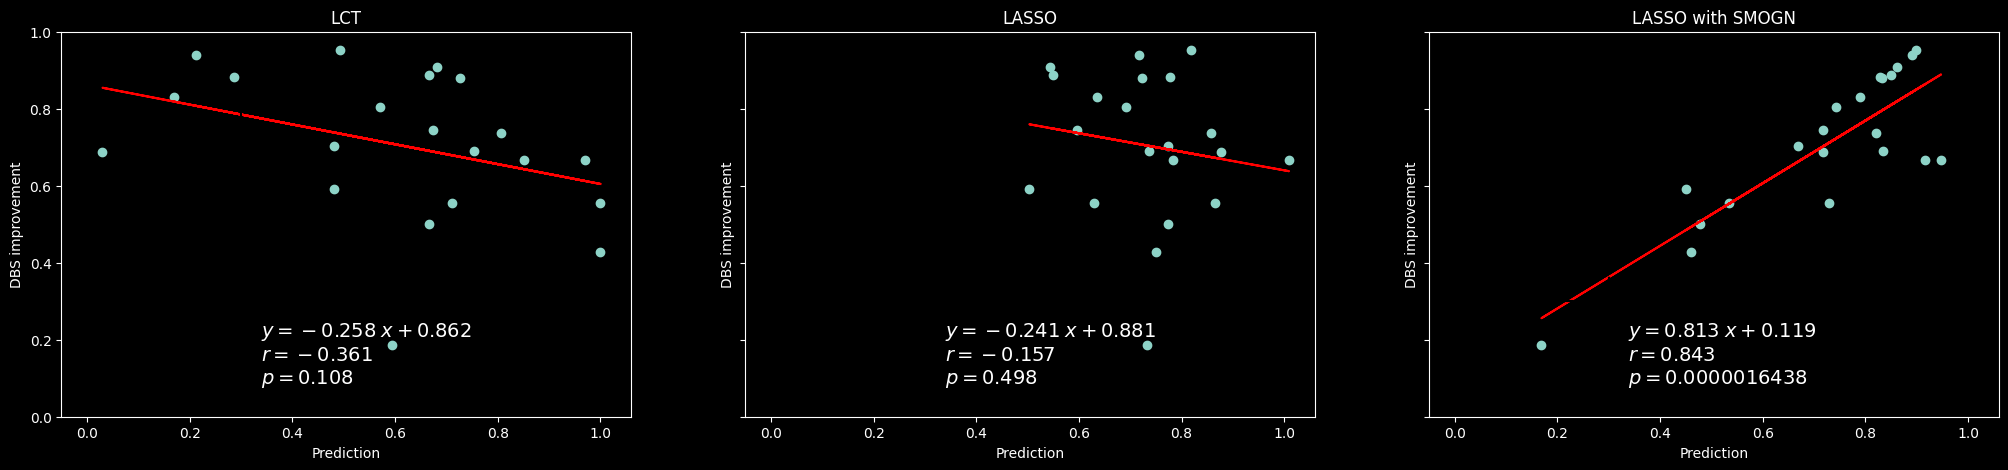

In [114]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,5)
# Cross validation results
[fig,ax] = plt.subplots(1,3,sharex=True, sharey=True)
lr_prepost = linregress(pre_dbs_meds_improvement_in,dbs_off_meds_improvement_in)
ax[0].scatter(pre_dbs_meds_improvement_in,dbs_off_meds_improvement_in,)
ax[0].plot(pre_dbs_meds_improvement_in,pre_dbs_meds_improvement_in*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
ax[0].set_ylim([0, 1])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.35, 0.25, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')
ax[0].hlines(0.3,0,1,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')

lr_pred_ls = linregress(ut_ls,dbs_off_meds_improvement_in)
ax[1].scatter(ut_ls,dbs_off_meds_improvement_in)
ax[1].plot(ut_ls,ut_ls*lr_pred_ls.slope+lr_pred_ls.intercept,'-r')
ax[1].set_title('LASSO')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_ls.slope:0.3f}\;x{lr_pred_ls.intercept:+0.3f}$\n$r = {lr_pred_ls.rvalue:0.3f}$\n$p = {lr_pred_ls.pvalue:0.3f}$"
ax[1].text(0.35, 0.25, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')
ax[1].hlines(0.3,0,1,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')


lr_pred_qr = linregress(ut_qr,dbs_off_meds_improvement_in)
ax[2].scatter(ut_qr,dbs_off_meds_improvement_in)
ax[2].plot(ut_qr,ut_qr*lr_pred_qr.slope+lr_pred_qr.intercept,'-r')
ax[2].set_title('LASSO with SMOGN')
ax[2].set_ylabel("DBS improvement")
ax[2].set_xlabel("Prediction")
text = f"$y={lr_pred_qr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qr.rvalue:0.3f}$\n$p = {lr_pred_qr.pvalue:0.10f}$"
ax[2].text(0.35, 0.25, text,transform=ax[2].transAxes,
     fontsize=14, verticalalignment='top')
ax[2].hlines(0.3,0,1,linestyle='dashed',color='black')
ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')

plt.style.use('default')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

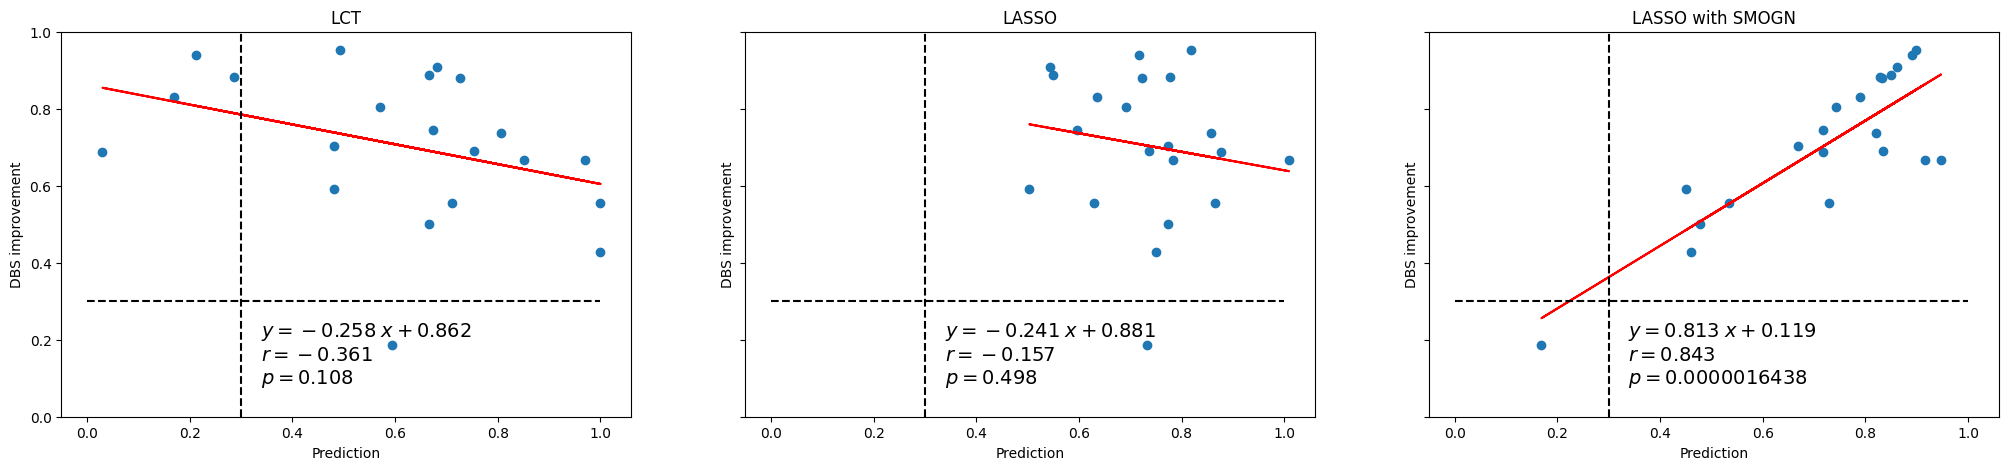

In [115]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,5)
# Cross validation results
[fig,ax] = plt.subplots(1,3,sharex=True, sharey=True)
lr_prepost = linregress(pre_dbs_meds_improvement_in,dbs_off_meds_improvement_in)
ax[0].scatter(pre_dbs_meds_improvement_in,dbs_off_meds_improvement_in,)
ax[0].plot(pre_dbs_meds_improvement_in,pre_dbs_meds_improvement_in*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
ax[0].set_ylim([0, 1])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.35, 0.25, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')
ax[0].hlines(0.3,0,1,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')

lr_pred_ls = linregress(ut_ls,dbs_off_meds_improvement_in)
ax[1].scatter(ut_ls,dbs_off_meds_improvement_in)
ax[1].plot(ut_ls,ut_ls*lr_pred_ls.slope+lr_pred_ls.intercept,'-r')
ax[1].set_title('LASSO')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_ls.slope:0.3f}\;x{lr_pred_ls.intercept:+0.3f}$\n$r = {lr_pred_ls.rvalue:0.3f}$\n$p = {lr_pred_ls.pvalue:0.3f}$"
ax[1].text(0.35, 0.25, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')
ax[1].hlines(0.3,0,1,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')


lr_pred_qr = linregress(ut_qr,dbs_off_meds_improvement_in)
ax[2].scatter(ut_qr,dbs_off_meds_improvement_in)
ax[2].plot(ut_qr,ut_qr*lr_pred_qr.slope+lr_pred_qr.intercept,'-r')
ax[2].set_title('LASSO with SMOGN')
ax[2].set_ylabel("DBS improvement")
ax[2].set_xlabel("Prediction")
text = f"$y={lr_pred_qr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qr.rvalue:0.3f}$\n$p = {lr_pred_qr.pvalue:0.10f}$"
ax[2].text(0.35, 0.25, text,transform=ax[2].transAxes,
     fontsize=14, verticalalignment='top')
ax[2].hlines(0.3,0,1,linestyle='dashed',color='black')
ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')

plt.style.use('default')
plt.show

In [116]:
# X_so = '/media/mts_dbs/dbs/all/npy/SMOGN/X_smogn_test_updrs_lr_c.npy'
# np.save(X_so,X_smogn_ds)

In [117]:
# import dill
# filepath = '/media/mts_dbs/dbs/all/pkls/msw_updrs_lr.pkl'
# dill.dump_session(filepath) # Save the session

In [118]:
# X_so = '/media/mts_dbs/dbs/all/npy/SMOGN/X_smogn_test_updrs_fr.npy'
# np.save(X_so,X_smogn)

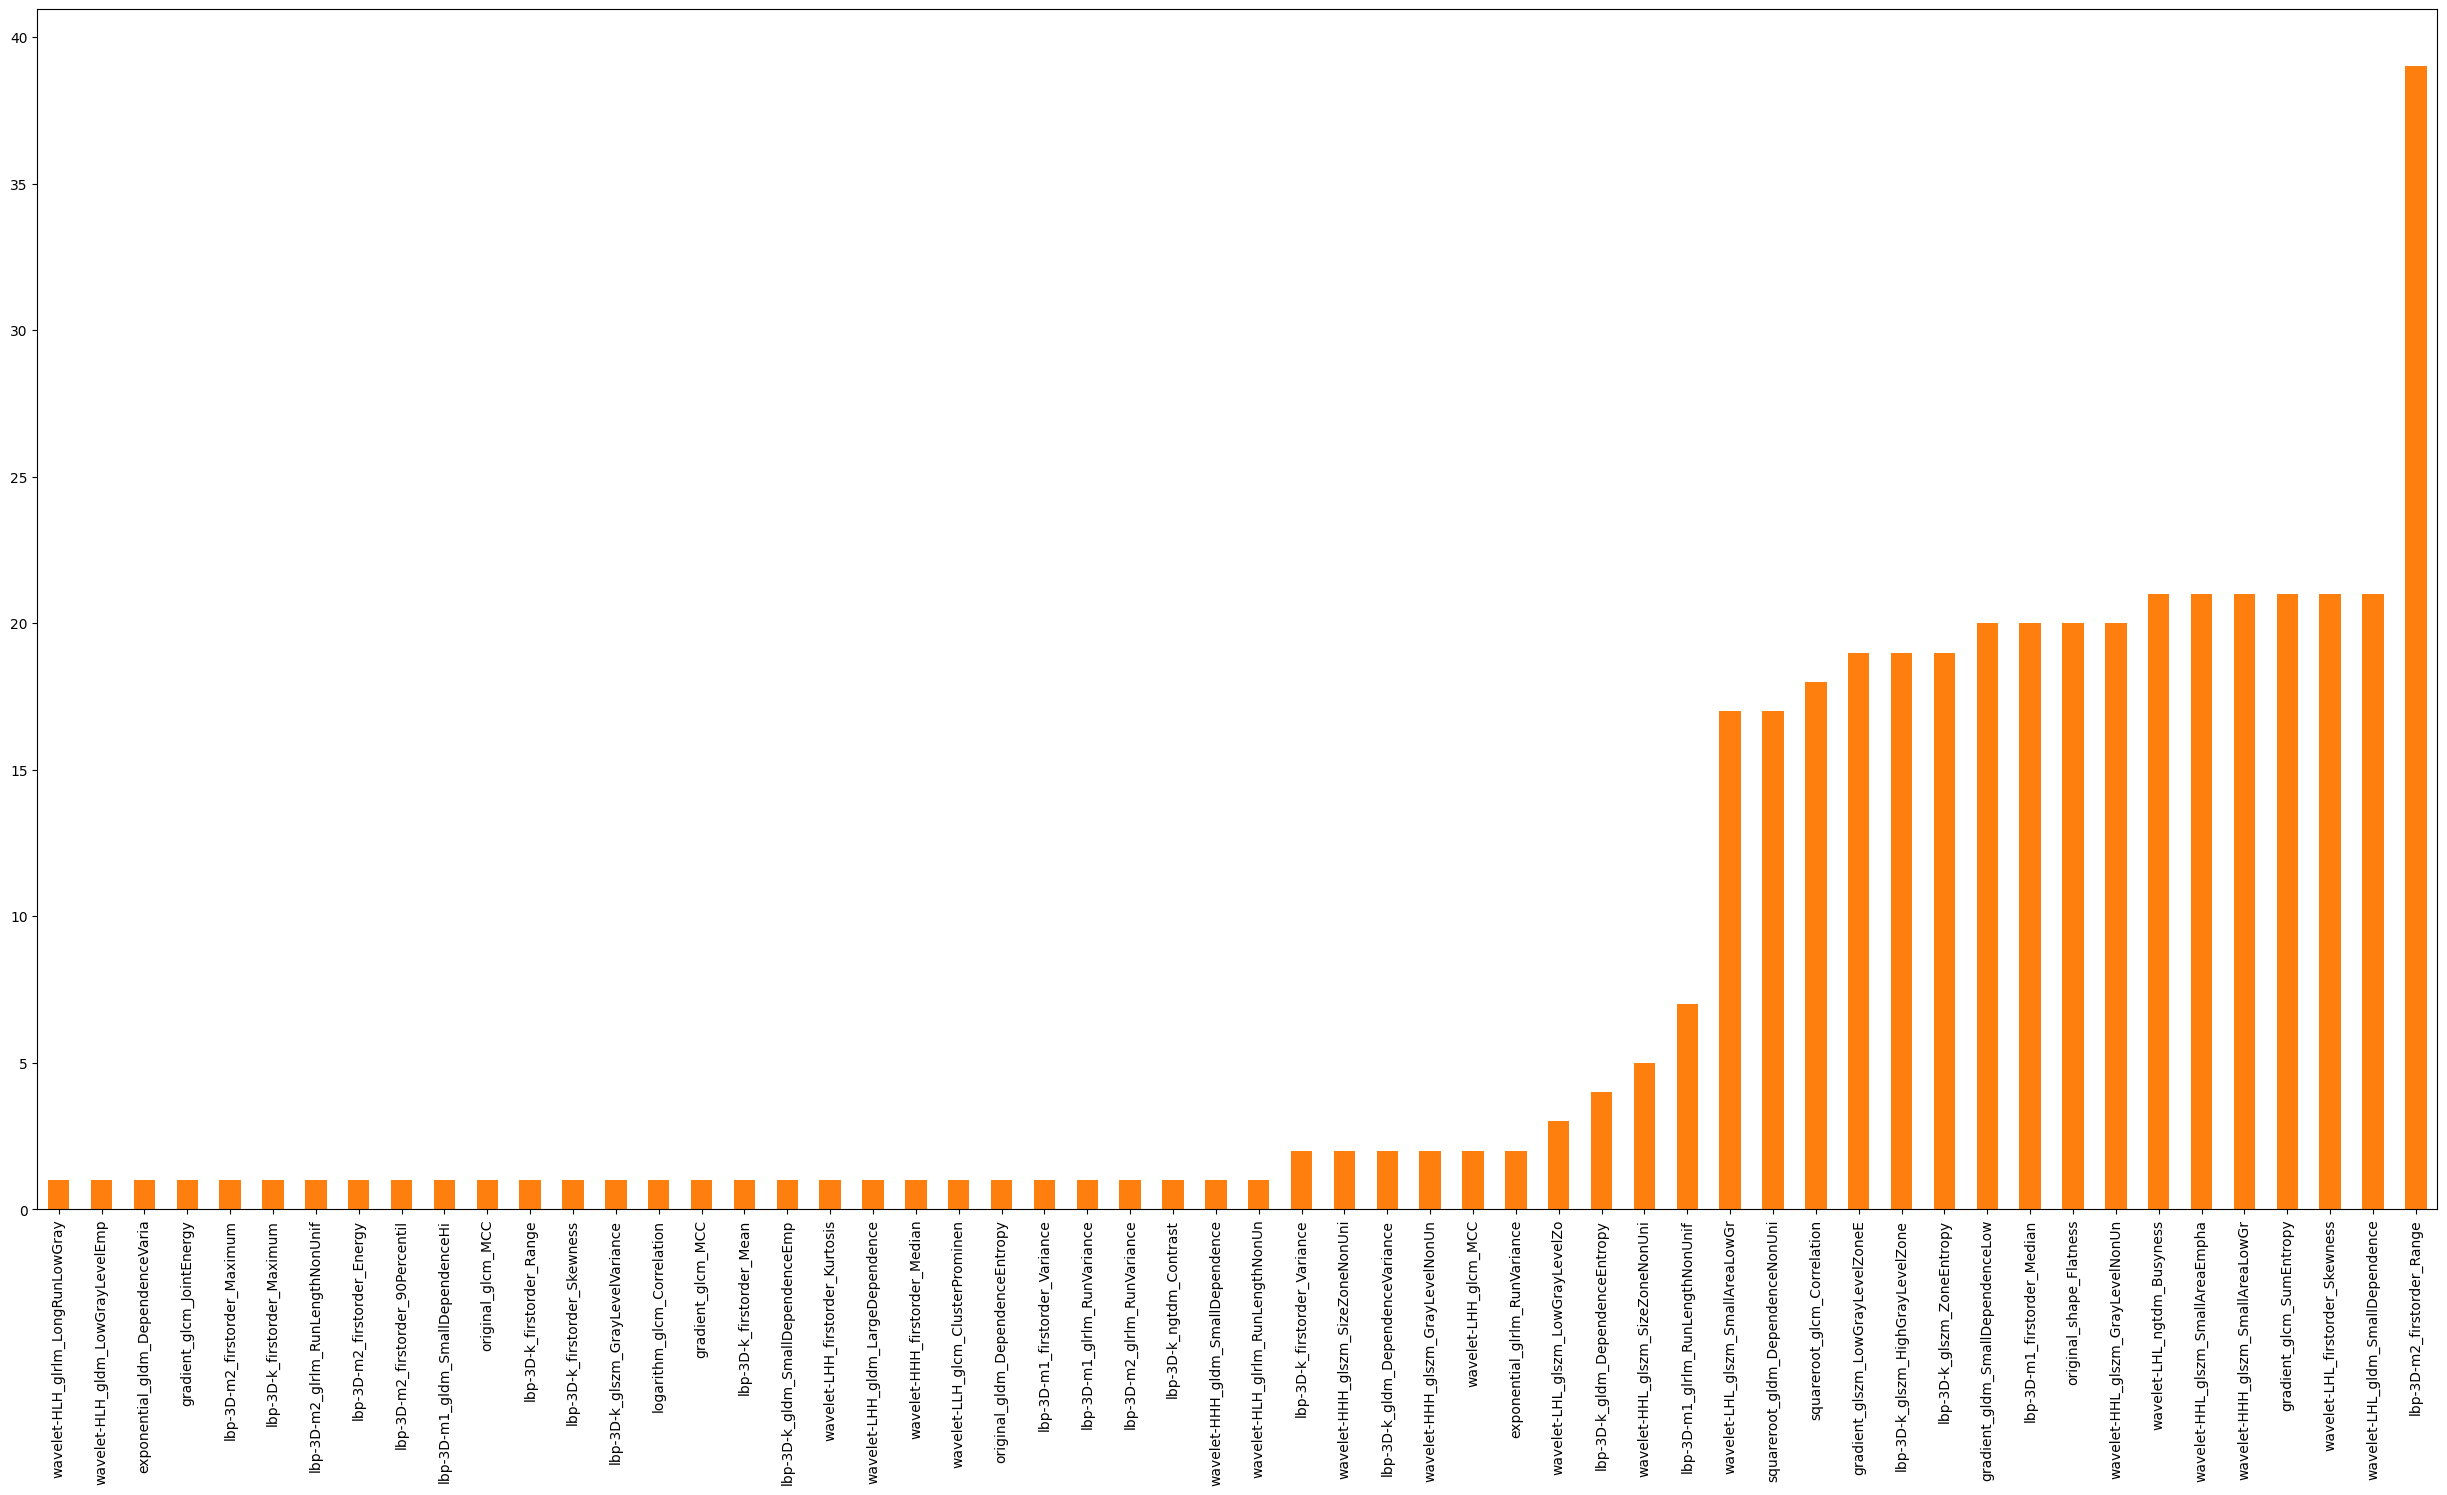

In [119]:
rfs = []
rfss = []
rfsr = []
rfsrs = []
for j in np.arange(n_cases):
    Kr =  K_all.reshape((n_cases,n_rois,(n_features-1))).transpose((0,2,1))
    #Rr =  R.reshape((n_cases,n_rois,(n_features-1))).transpose((0,2,1))
    Kr_extended = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1)).astype('str')
    #Rr_extended = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1)).astype('str')
    Kr_extended[:,0:n_features-1,:] = Kr
    #Rr_extended[:,0:n_features-1,:] = Rr
    Kr_extended[:,-1,:] = 'po_updrs'
    rfs.append(Kr_extended[j,np.asarray(Cs_ds[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
   # rfsr.append(Rr_extended[j,np.asarray(Ct[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
    if j < Cs_ds.shape[0]:
        rfss.append(Kr_extended[j,np.asarray(Cs_ds[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
        #rfsrs.append(Rr_extended[j,np.asarray(Ct[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])

plt.rcParams["figure.figsize"] = (30,15)
fig, axes = plt.subplots(1,1,sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

R = [item for sublist in rfs for item in sublist]
letter_counts = Counter(R)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')


Rs = [item for sublist in rfss for item in sublist]
letter_countss = Counter(Rs)
dfs = pandas.DataFrame.from_dict(letter_countss, orient='index')


uL = list(compress(R, np.in1d(R,Rs)))
colors = np.zeros_like(R)
for j in np.arange(R.__len__()):
    if R[j] in uL:
        colors[j] = "tab:orange"
    else:
        colors[j] = "tab:blue"


df.sort_values(0, inplace=True)
df.plot(ax=axes,y=0, kind='bar', legend=False, color=colors)
# dfs.sort_values(0, inplace=True)
# dfs.plot(ax=axes[1],y=0, kind='bar', legend=False, color=colors)
plt.style.use('dark_background')



In [120]:
rfs = []
rfss = []
rfsr = []
rfsrs = []
for j in np.arange(Cs.shape[0]-1):
    Kr =  K_all.reshape((n_cases,n_rois,(n_features-1))).transpose((0,2,1))
    #Rr =  R.reshape((n_cases,n_rois,(n_features-1))).transpose((0,2,1))
    Kr_extended = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1)).astype('str')
    #Rr_extended = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1)).astype('str')
    Kr_extended[:,0:n_features-1,:] = Kr
    #Rr_extended[:,0:n_features-1,:] = Rr
    Kr_extended[:,-1,:] = 'po_updrs'
    rfs.append(Kr_extended[j,np.asarray(Cs[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
   # rfsr.append(Rr_extended[j,np.asarray(Ct[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
    if j < Cs.shape[0]:
        rfss.append(Kr_extended[j,np.asarray(Cs[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
        #rfsrs.append(Rr_extended[j,np.asarray(Ct[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])

plt.rcParams["figure.figsize"] = (30,15)
fig, axes = plt.subplots(1,1,sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

R = [item for sublist in rfs for item in sublist]
letter_counts = Counter(R)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')


Rs = [item for sublist in rfss for item in sublist]
letter_countss = Counter(Rs)
dfs = pandas.DataFrame.from_dict(letter_countss, orient='index')


uL = list(compress(R, np.in1d(R,Rs)))
colors = np.zeros_like(R)
for j in np.arange(R.__len__()):
    if R[j] in uL:
        colors[j] = "tab:orange"
    else:
        colors[j] = "tab:blue"


df.sort_values(0, inplace=True)
df.plot(ax=axes,y=0, kind='bar', legend=False, color=colors)
# dfs.sort_values(0, inplace=True)
# dfs.plot(ax=axes[1],y=0, kind='bar', legend=False, color=colors)
plt.style.use('dark_background')



NameError: name 'Cs' is not defined

In [ ]:
alphas = np.logspace(-10, 5, 75)
solution_norm = []
residual_norm = []
X = X_all_t
y = dbs_off_meds_improvement_in
for alpha in alphas: 
    lm = Lasso(alpha=alpha,max_iter=10000)
    lm.fit(X, y)
    solution_norm += [(lm.coef_**2).sum()]
    residual_norm += [((lm.predict(X) - y)**2).sum()]

plt.loglog(residual_norm, solution_norm, 'k-')
for i, txt in enumerate(alphas):
    if np.mod(i,10)==0:
        plt.annotate(str('{:.2e}'.format(float(txt))), (residual_norm[i], solution_norm[i]))
plt.show()
plt.style.use('default')